# Identifying an Ideal Location for a Supplement Shop in Manhattan

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
from pandas import json_normalize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import collections
 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

     |████████████████████████████████| 94 kB 3.9 MB/s eta 0:00:011


## 1. Download and Explore Dataset

Download the dataset that contains the 5 boroughs and the neighborhoods that exist in each borough in New York, as well as the the latitude and logitude coordinates of each neighborhood from the below link.

In [3]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


Next, let's load the data

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Let's take a quick look at the data.

In [5]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

Notice that all the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [6]:
neighborhoods_data = newyork_data['features']

Let's take a look at the first item in this list.

In [7]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Next transform this data of nested Python dictionaries into a pandas dataframe. So let's start by creating an empty dataframe.

In [8]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Take a look at the empty dataframe to confirm that the columns are as intended.

In [9]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Then let's loop through the data and fill the dataframe one row at a time.

In [10]:
for data in neighborhoods_data:
    borough = data['properties']['borough']
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Quickly examine the resulting dataframe.

In [11]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(neighborhoods['Borough'].unique()), neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


Since we are interested only in the data related to Manhattan borough, let's slice the original dataframe and create a new dataframe of the Manhattan data.

In [13]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
manhattan_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Manhattan,Marble Hill,40.876551,-73.910660
1,Manhattan,Chinatown,40.715618,-73.994279
2,Manhattan,Washington Heights,40.851903,-73.936900
3,Manhattan,Inwood,40.867684,-73.921210
4,Manhattan,Hamilton Heights,40.823604,-73.949688


Let's get the geographical coordinates of Manhattan.

In [14]:
address = 'Manhattan, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7896239, -73.9598939.


Now let's visualizat Manhattan the neighborhoods in it.

In [15]:
# create map of Manhattan using latitude and longitude values
map_manhattan = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(manhattan_data['Latitude'], manhattan_data['Longitude'], manhattan_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_manhattan)  
    
map_manhattan

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods.

Define Foursquare Credentials and Version

In [16]:
# The code was removed by Watson Studio for sharing.

In [17]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Call foursquare API to get the details regarding popular venues around each neighborhood and process the output obtained.

In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
                    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'], latitudes=manhattan_data['Latitude'], longitudes=manhattan_data['Longitude'])

Let's check the size of the resulting dataframe

In [20]:
print(manhattan_venues.shape)
manhattan_venues.head()

(3167, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marble Hill,40.876551,-73.91066,Arturo's,40.874412,-73.910271,Pizza Place
1,Marble Hill,40.876551,-73.91066,Bikram Yoga,40.876844,-73.906204,Yoga Studio
2,Marble Hill,40.876551,-73.91066,Tibbett Diner,40.880404,-73.908937,Diner
3,Marble Hill,40.876551,-73.91066,Starbucks,40.877531,-73.905582,Coffee Shop
4,Marble Hill,40.876551,-73.91066,Dunkin',40.877136,-73.906666,Donut Shop


Let's check how many venues were returned for each neighborhood

In [21]:
manhattan_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Battery Park City,70,70,70,70,70,70
Carnegie Hill,86,86,86,86,86,86
Central Harlem,46,46,46,46,46,46
Chelsea,100,100,100,100,100,100
Chinatown,100,100,100,100,100,100
Civic Center,100,100,100,100,100,100
Clinton,100,100,100,100,100,100
East Harlem,38,38,38,38,38,38
East Village,100,100,100,100,100,100


Let's find out how many unique categories can be curated from all the returned venues

In [22]:
print('There are {} uniques categories.'.format(len(manhattan_venues['Venue Category'].unique())))

There are 335 uniques categories.


Analyzing each neighborhood

In [23]:
# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_onehot.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Sho

Let's examine the new dataframe size.

In [24]:
manhattan_onehot.shape

(3167, 336)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [25]:
manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Christmas Market,Circus,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Arts Building,College Bookstore,College Cafeteria,College Theater,Comedy Club,Community Center,Concert Hall,Convenience Store,Cooking School,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Stand,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,High School,Hill,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Laundry Service,Lebanese Restaurant,Library,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Newsstand,Nightclub,Non-Profit,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Outdoors & Recreation,Paella Restaurant,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Service,Pet Store,Pharmacy,Photography Studio,Physical Therapist,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Post Office,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Residential Building (Apartment / Condo),Resort,Rest Area,Restaurant,River,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Shipping Store,Sho

In [26]:
manhattan_grouped.shape

(40, 336)

Let's put that details of each neighborhood along with the top 10 most common venuesinto a pandas dataframe

First, let's write a function to sort the venues in descending order.

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = manhattan_grouped['Neighborhood']

for ind in np.arange(manhattan_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(manhattan_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Battery Park City,Coffee Shop,Hotel,Park,Memorial Site,Gym,Clothing Store,Burger Joint,Gourmet Shop,BBQ Joint,Plaza
1,Carnegie Hill,Coffee Shop,Café,Yoga Studio,Wine Shop,Bookstore,Pizza Place,Gym,Cosmetics Shop,Japanese Restaurant,Cocktail Bar
2,Central Harlem,African Restaurant,Seafood Restaurant,Art Gallery,Bar,French Restaurant,Chinese Restaurant,Cosmetics Shop,Gym / Fitness Center,American Restaurant,Park
3,Chelsea,Coffee Shop,Bakery,American Restaurant,French Restaurant,Art Gallery,Ice Cream Shop,Wine Shop,Seafood Restaurant,Cupcake Shop,Bookstore
4,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Hotpot Restaurant,Salon / Barbershop,Spa,American Restaurant,Optical Shop,Dessert Shop,Ice Cream Shop


## Cluster Neighborhoods

In order to identify the optimal value of k to be used in k-means clustering, lets iterate the model with various values of k,calculate the error(cost) associated with each k value. then plot the values of cost for each k, to identify the elbow point.

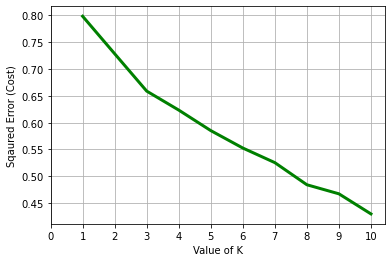

In [29]:
cost =[]
manhattan_grouped_clustering = manhattan_grouped.drop('Neighborhood', 1)
for i in range(1, 11): 
    KM = KMeans(n_clusters = i, max_iter = 500) 
    KM.fit(manhattan_grouped_clustering) 
      
    # calculates squared error for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)")
plt.grid(b = True, axis ='both')
plt.xticks(np.arange(0, 11, step=1))
plt.show() # clear the plot

From the above plot we infer that the elbow point occurs at k = 3

Run k-means to cluster the neighborhood into 3 clusters.

In [30]:
# set number of clusters
kclusters = 3

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 2, 2, 2, 2, 2, 1, 1, 2], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [31]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

manhattan_merged = manhattan_data

# merge manhattan_data with neighborhoods_venues_sorted to add latitude/longitude for each neighborhood
manhattan_merged = manhattan_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

manhattan_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Manhattan,Marble Hill,40.876551,-73.910660,2,Sandwich Place,Gym,Coffee Shop,Discount Store,Pharmacy,Steakhouse,Supplement Shop,Seafood Restaurant,Tennis Stadium,Donut Shop
1,Manhattan,Chinatown,40.715618,-73.994279,2,Chinese Restaurant,Bakery,Cocktail Bar,Hotpot Restaurant,Salon / Barbershop,Spa,American Restaurant,Optical Shop,Dessert Shop,Ice Cream Shop
2,Manhattan,Washington Heights,40.851903,-73.936900,1,Café,Bakery,Bank,Mobile Phone Shop,Grocery Store,Chinese Restaurant,Shoe Store,Italian Restaurant,Latin American Restaurant,Tapas Restaurant
3,Manhattan,Inwood,40.867684,-73.921210,1,Mexican Restaurant,Restaurant,Café,Lounge,Bakery,Pizza Place,Park,Chinese Restaurant,Caribbean Restaurant,Frozen Yogurt Shop
4,Manhattan,Hamilton Heights,40.823604,-73.949688,1,Pizza Place,Café,Coffee Shop,Mexican Restaurant,Deli / Bodega,Yoga Studio,Latin American Restaurant,Park,Liquor Store,Cocktail Bar


Finally, let's visualize the resulting clusters

In [32]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster

In [39]:
# this function plots the frequency distribution of different venue categories in each cluster.
def frequency_dist(cluster):
    df = cluster.iloc[:,1:]
    length = len(df.index)
    new_list = []
    for n in range(0,length):
        arr = df.values[n]
        for i in range(0,9):
            new_list.append(arr[i])
    new_list

    dict = collections.Counter(new_list)

    frqdist = pd.DataFrame.from_dict(dict, orient = 'index', columns = ['Frequency'])

    frqdist['Relative Frequency'] = round((frqdist['Frequency']/(frqdist['Frequency'].sum()))*100, 2)
    frqdist.sort_values('Relative Frequency', ascending = True, inplace = True)#.reset_index(inplace = True)
    print(frqdist)
    frqdist.plot(kind = 'bar', y='Relative Frequency', figsize = (20,8), color = 'skyblue')
    plt.show() 

### Cluster 1

In [35]:
cluster1 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 0, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster1

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,Stuyvesant Town,Park,Bar,Coffee Shop,Pet Service,Baseball Field,Gym / Fitness Center,Cocktail Bar,Heliport,Farmers Market,Harbor / Marina


                      Frequency  Relative Frequency
Park                          1               11.11
Bar                           1               11.11
Coffee Shop                   1               11.11
Pet Service                   1               11.11
Baseball Field                1               11.11
Gym / Fitness Center          1               11.11
Cocktail Bar                  1               11.11
Heliport                      1               11.11
Farmers Market                1               11.11


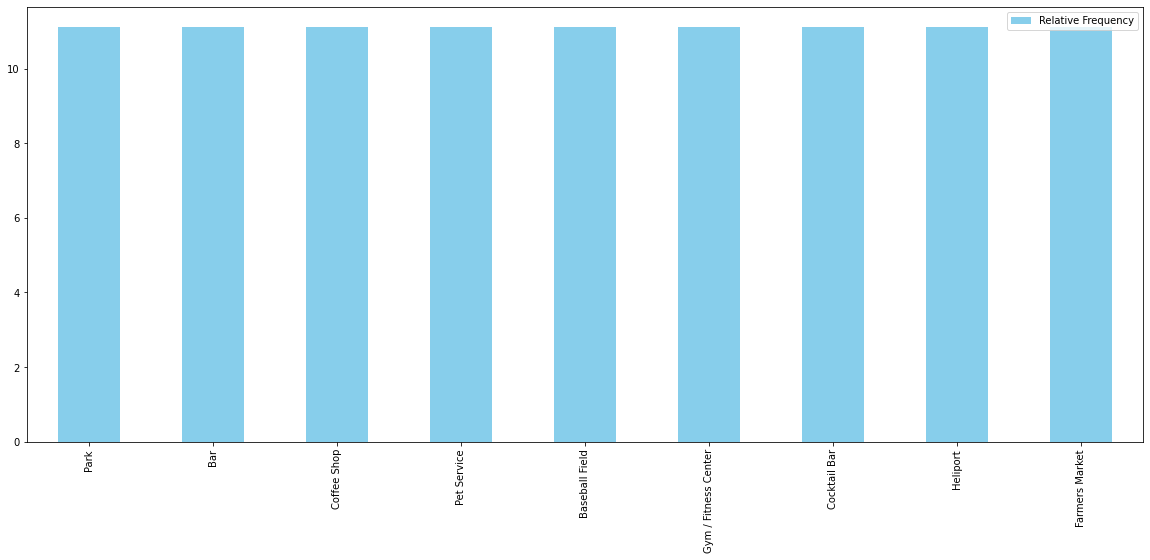

In [40]:
frequency_dist(cluster1)

### Cluster 2

In [37]:
cluster2 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 1, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster2

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Washington Heights,Café,Bakery,Bank,Mobile Phone Shop,Grocery Store,Chinese Restaurant,Shoe Store,Italian Restaurant,Latin American Restaurant,Tapas Restaurant
3,Inwood,Mexican Restaurant,Restaurant,Café,Lounge,Bakery,Pizza Place,Park,Chinese Restaurant,Caribbean Restaurant,Frozen Yogurt Shop
4,Hamilton Heights,Pizza Place,Café,Coffee Shop,Mexican Restaurant,Deli / Bodega,Yoga Studio,Latin American Restaurant,Park,Liquor Store,Cocktail Bar
5,Manhattanville,Coffee Shop,Seafood Restaurant,Sushi Restaurant,Mexican Restaurant,Italian Restaurant,Boutique,Spanish Restaurant,Burger Joint,Bus Station,Cuban Restaurant
7,East Harlem,Mexican Restaurant,Deli / Bodega,Thai Restaurant,Bakery,Sandwich Place,Latin American Restaurant,Dance Studio,Taco Place,Gas Station,Beer Bar
9,Yorkville,Italian Restaurant,Coffee Shop,Gym,Bar,Deli / Bodega,Sushi Restaurant,Diner,Japanese Restaurant,Wine Shop,Vietnamese Restaurant
10,Lenox Hill,Italian Restaurant,Coffee Shop,Sushi Restaurant,Cocktail Bar,Café,Pizza Place,Gym,Burger Joint,Gym / Fitness Center,Mexican Restaurant
12,Upper West Side,Bar,Café,Wine Bar,Bakery,Italian Restaurant,Breakfast Spot,Indian Restaurant,Bagel Shop,Pub,Coffee Shop
19,East Village,Bar,Pizza Place,Wine Bar,Salon / Barbershop,Korean Restaurant,Mexican Restaurant,Vietnamese Restaurant,Coffee Shop,Juice Bar,Japanese Restaurant
20,Lower East Side,Chinese Restaurant,Bakery,Café,Art Gallery,Japanese Restaurant,Latin American Restaurant,Yoga Studio,Mediterranean Restaurant,Bubble Tea Shop,Diner


                           Frequency  Relative Frequency
Dance Studio                       1                0.74
Bus Station                        1                0.74
Sandwich Place                     1                0.74
Hotel                              1                0.74
Taco Place                         1                0.74
Gas Station                        1                0.74
Diner                              1                0.74
Breakfast Spot                     1                0.74
Pub                                1                0.74
Spanish Restaurant                 1                0.74
Salon / Barbershop                 1                0.74
Vietnamese Restaurant              1                0.74
Juice Bar                          1                0.74
Mediterranean Restaurant           1                0.74
Bubble Tea Shop                    1                0.74
Clothing Store                     1                0.74
American Restaurant            

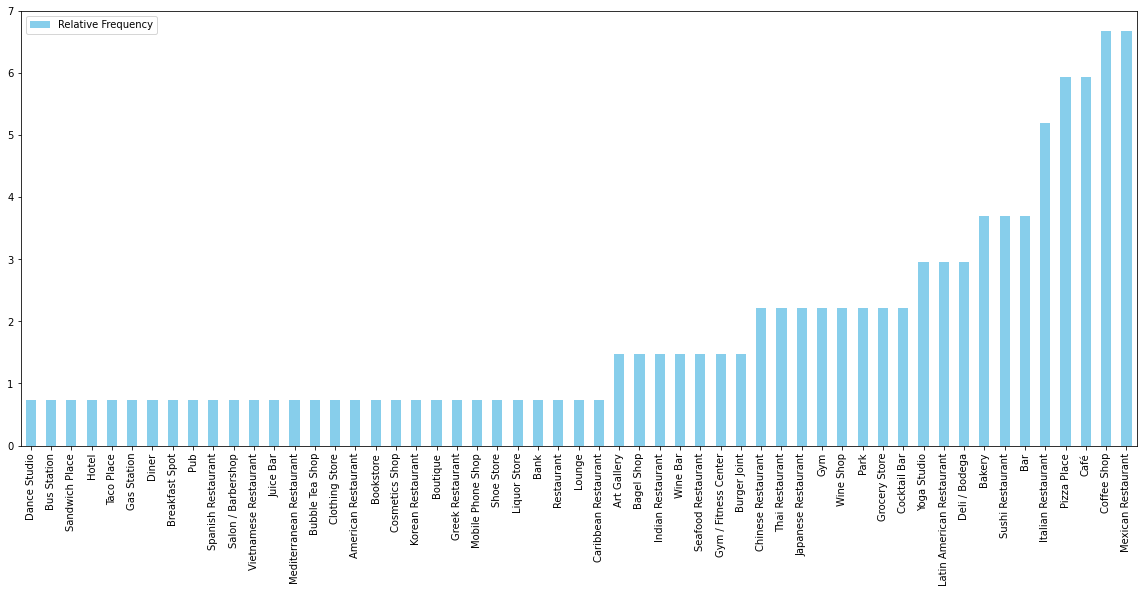

In [41]:
frequency_dist(cluster2)

### Cluster 3

In [42]:
cluster3 = manhattan_merged.loc[manhattan_merged['Cluster Labels'] == 2, manhattan_merged.columns[[1] + list(range(5, manhattan_merged.shape[1]))]]
cluster3

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Marble Hill,Sandwich Place,Gym,Coffee Shop,Discount Store,Pharmacy,Steakhouse,Supplement Shop,Seafood Restaurant,Tennis Stadium,Donut Shop
1,Chinatown,Chinese Restaurant,Bakery,Cocktail Bar,Hotpot Restaurant,Salon / Barbershop,Spa,American Restaurant,Optical Shop,Dessert Shop,Ice Cream Shop
6,Central Harlem,African Restaurant,Seafood Restaurant,Art Gallery,Bar,French Restaurant,Chinese Restaurant,Cosmetics Shop,Gym / Fitness Center,American Restaurant,Park
8,Upper East Side,Coffee Shop,Italian Restaurant,Exhibit,Bakery,Gym / Fitness Center,American Restaurant,Yoga Studio,Juice Bar,Cosmetics Shop,Spa
11,Roosevelt Island,Park,Monument / Landmark,Kosher Restaurant,Food & Drink Shop,Soccer Field,Farmers Market,Supermarket,Metro Station,School,Outdoors & Recreation
13,Lincoln Square,Gym / Fitness Center,Café,Plaza,Theater,Concert Hall,Italian Restaurant,Performing Arts Venue,Indie Movie Theater,Wine Shop,Mexican Restaurant
14,Clinton,Italian Restaurant,Coffee Shop,Gym / Fitness Center,Theater,Gym,Wine Shop,American Restaurant,Cocktail Bar,Hotel,Sandwich Place
15,Midtown,Hotel,Coffee Shop,Clothing Store,Theater,Sporting Goods Shop,Steakhouse,Sandwich Place,Bakery,Gym,Bookstore
16,Murray Hill,Sandwich Place,Coffee Shop,Bar,American Restaurant,Hotel,Japanese Restaurant,Burger Joint,Gym / Fitness Center,Gym,Mediterranean Restaurant
17,Chelsea,Coffee Shop,Bakery,American Restaurant,French Restaurant,Art Gallery,Ice Cream Shop,Wine Shop,Seafood Restaurant,Cupcake Shop,Bookstore


                          Frequency  Relative Frequency
Restaurant                        1                0.46
Grocery Store                     1                0.46
Monument / Landmark               1                0.46
Kosher Restaurant                 1                0.46
Food & Drink Shop                 1                0.46
Soccer Field                      1                0.46
Farmers Market                    1                0.46
Supermarket                       1                0.46
Metro Station                     1                0.46
School                            1                0.46
Dog Run                           1                0.46
Plaza                             1                0.46
Greek Restaurant                  1                0.46
Concert Hall                      1                0.46
Performing Arts Venue             1                0.46
Indie Movie Theater               1                0.46
Bookstore                         1             

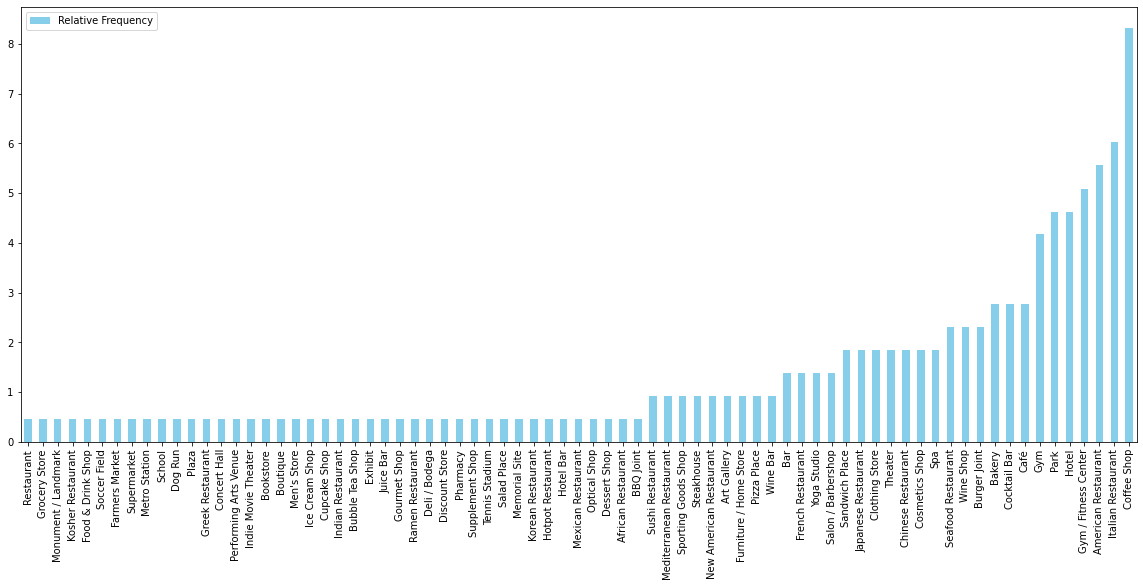

In [43]:
frequency_dist(cluster3)

## Inference

From the above frequency distribution plots we notice that Cluster 1 is a very unique cluster. It has only one neighborhood and it has no restaurants. To confirm this further lets take a list of all venues instead of top venues around this neighborhood.

In [48]:
clust1 = manhattan_data[manhattan_data['Neighborhood'] == 'Stuyvesant Town']
clust1

,Borough,Neighborhood,Latitude,Longitude
37,Manhattan,Stuyvesant Town,40.731,-73.974052


First, let's create the GET request URL. Name your URL url.

In [53]:
neighborhood_latitude = 40.731 # neighborhood latitude value
neighborhood_longitude = -73.974052 # neighborhood longitude value

print('Latitude and longitude values are {}, {}.'.format(neighborhood_latitude, neighborhood_longitude))

Latitude and longitude values are 40.731, -73.974052.


In [54]:
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)


Send the GET request and examine the resutls

In [55]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60203d92a82a1d192bfb264c'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Stuyvesant Town - Peter Cooper Village',
  'headerFullLocation': 'Stuyvesant Town - Peter Cooper Village, New York',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 16,
  'suggestedBounds': {'ne': {'lat': 40.735500004500004,
    'lng': -73.9681246937336},
   'sw': {'lat': 40.7264999955, 'lng': -73.9799793062664}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4a7b69a3f964a520edea1fe3',
       'name': 'Stuyvesant Cove Park',
       'location': {'address': '20th St and FDR',
        'crossStreet': 'at E 20th St',
        'lat': 40.73251294059505,
       

Now let's clean the json and structure it into a pandas dataframe.

In [56]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Stuyvesant Cove Park,Park,40.732513,-73.973876
1,Con Ed Field,Baseball Field,40.729206,-73.973732
2,Stuyvesant Oval,Park,40.731665,-73.977835
3,StuyFitness,Gym / Fitness Center,40.729013,-73.976676
4,Pouring Ribbons,Cocktail Bar,40.729093,-73.978033


Let's check the size

In [57]:
nearby_venues.shape

(16, 4)

In [58]:
nearby_venues

,name,categories,lat,lng
0,Stuyvesant Cove Park,Park,40.732513,-73.973876
1,Con Ed Field,Baseball Field,40.729206,-73.973732
2,Stuyvesant Oval,Park,40.731665,-73.977835
3,StuyFitness,Gym / Fitness Center,40.729013,-73.976676
4,Pouring Ribbons,Cocktail Bar,40.729093,-73.978033
5,Stuyvesant Oval Fountain,Fountain,40.731987,-73.977685
6,Stuyvesant Town Greenmarket,Farmers Market,40.731429,-73.978222
7,The Roost,Bar,40.729084,-73.978638
8,Unleashed Spa & Self Pet Wash,Pet Service,40.728984,-73.978380
9,B Cup Cafe,Coffee Shop,40.728783,-73.978565


We notice that the neighborhood is characterised by the presence of outdoor recreational activities like baseball field, park etc.
Lets visualize this data

Park                    3
Coffee Shop             2
Bar                     2
Fountain                1
Cocktail Bar            1
Gym / Fitness Center    1
Heliport                1
Baseball Field          1
Pet Service             1
Farmers Market          1
Gas Station             1
Harbor / Marina         1
Name: categories, dtype: int64


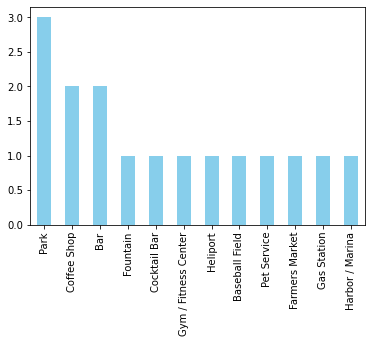

In [59]:
freq = nearby_venues['categories'].value_counts()
print(freq)
freq.plot(kind = 'bar', color = 'skyblue')
plt.show()

As can be noticed Stuyvesant Town is a hub of fitness and sports related activities. Hence this would be a perfect location to set up a Supplement Shop. A juice bar, salad shop, yoga studio, dance studio etc are some other promising ventures in this areas as all these are not present in this neighborhood, but would be successful as it goes with the characteristics of this clusture